In [1]:

import random
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline 

import time, os, csv
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
#import multiprocessing

In [2]:
root_dir = os.path.abspath('C:\IPythonNotebook')
data_dir = os.path.join(root_dir, 'SynCDOData')

# check for existence
print(os.path.exists(root_dir))
print(os.path.exists(data_dir))

True
True


In [3]:
LABEL_COLUMN_FOR_TRAINING = "el"
#columnsToExclude = ["TradeId","PathId","trType","ccy","pv","el","elp","acrd"]
columnsToExclude = ["trType","ccy","pv","el","elp","acrd"]

In [4]:
# Helper function to get the data we need from a DF
def GetDataFromDF(df):
    
    # input
    # df : Dataframe containing CDO data
    # ouput
    # label, values 
    print("len(df)=",len(df))
    df=df.drop_duplicates(subset=list(set(df.columns)-set(["TradeId","PathId"])))
    print("len(df) after removing duplicates = ",len(df))
    
    labels = df[LABEL_COLUMN_FOR_TRAINING].values.reshape(len(df),1)
    
    removeRecoveries = False
    if removeRecoveries :
        recCols = [s for s in df.columns if "R_" in s]
        df = df.drop(recCols, axis=1) 
        
    useTradeType = False
    if useTradeType :
        df["IsIndex"] = (df["trType"] == "INDTR")+0 # create a new column with 0/1
        
    for item in columnsToExclude :
        if item in df :
            del df[item]
    
    values = df.values
    
    return labels, values 

In [5]:
# read the data
dataDF_temp = pd.read_csv(os.path.join(data_dir, 'data_wRec.csv'), nrows=20)
#dataDF_temp = pd.read_csv(os.path.join(data_dir, 'data.csv'), nrows=20)
#dataDF_temp['mat'] = pd.to_datetime(dataDF_temp['mat'])-pd.to_datetime('2017-10-06')
#dataDF_temp['mat'] = dataDF_temp['mat'].dt.days
dataDF_temp['mat'] = dataDF_temp['mat'] - 43014 # 43014 = 2017-10-06
allset_labels_tmp, allset_data_tmp = GetDataFromDF(dataDF_temp)

len(df)= 20
len(df) after removing duplicates =  19


In [6]:
allset_data_tmp[:,2:].shape[1] # 2: is to exclude PathId and TradeId from the count.

1290

In [61]:
# read the data
dataDF = pd.read_csv(os.path.join(data_dir, 'data_wRec.csv'), nrows=5000)
#dataDF['mat'] = pd.to_datetime(dataDF['mat'])-pd.to_datetime('2017-10-06')
#dataDF['mat'] = dataDF['mat'].dt.days
dataDF['mat'] = dataDF['mat'] - 43014 # 43014 = 2017-10-06
allset_labels, allset_data = GetDataFromDF(dataDF)
del dataDF

len(df)= 5000
len(df) after removing duplicates =  4656


In [62]:
X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(allset_data, allset_labels, test_size=0.2, random_state=65) #42
X_train_unscaled, X_dev_unscaled, y_train_unscaled, y_dev_unscaled = train_test_split(X_train_unscaled, y_train_unscaled, test_size=0.5, random_state=53) #42

In [63]:
# Data size
print({"Training Set":y_train_unscaled.shape[0]},{"Validation Set":y_dev_unscaled.shape[0]},{"Test Set":y_test_unscaled.shape[0]})
print("Nb features :",X_train_unscaled[:,2:].shape[1]) # "2:" is there in order to exclude trade Id and path Id

{'Training Set': 1862} {'Validation Set': 1862} {'Test Set': 932}
Nb features : 1290


In [64]:
#StandardScaler()
minmax_x = preprocessing.MinMaxScaler(feature_range=(0,1), copy=True)
#minmax_x = preprocessing.QuantileTransformer(output_distribution='normal')
X_train = minmax_x.fit_transform(X_train_unscaled[:,2:])
X_dev = minmax_x.fit_transform(X_dev_unscaled[:,2:])
X_test = minmax_x.transform(X_test_unscaled[:,2:])

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [65]:
#minmax_y = preprocessing.MinMaxScaler(feature_range=(0,1), copy=True)
minmax_y = preprocessing.QuantileTransformer(output_distribution='normal', random_state=31)
#minmax_y = preprocessing.StandardScaler()
y_train = minmax_y.fit_transform(y_train_unscaled)
y_dev = minmax_y.fit_transform(y_dev_unscaled)

In [66]:
# several kernel functions
def scaled_square_dist(lengthscales, X, X2=None):
    X = X / lengthscales
    Xs = tf.reduce_sum(tf.square(X), axis=1)
    
    if X2 is None:
        dist = -2 * tf.matmul(X, X, transpose_b=True)
        dist += tf.reshape(Xs, (-1, 1))  + tf.reshape(Xs, (1, -1))
        return dist
    
    X2 = X2 / lengthscales
    X2s = tf.reduce_sum(tf.square(X2), axis=1)
    dist = -2 * tf.matmul(X, X2, transpose_b=True)
    dist += tf.reshape(Xs, (-1, 1)) + tf.reshape(X2s, (1, -1))
    return dist

def scaled_euclid_dist(lengthscales, X, X2=None):
    """
    Returns |(X - X2ᵀ)/lengthscales| (L2-norm).
    """
    r2 = scaled_square_dist(lengthscales,X, X2)
    # Clipping around the (single) float precision which is ~1e-45.
    return tf.sqrt(tf.maximum(r2, 1e-20))

"""
def rbf(lengthscale,sigma,X,X2=None):
    n,d =X.shape

    cons = tf.constant(1e-4,dtype=tf.float32)
    X = X / lengthscale
    Xs = tf.reduce_sum(tf.square(X), axis=1,keepdims=True)

    temp1 = tf.add(Xs,tf.transpose(Xs))
    temp2 = -2*tf.matmul(X,tf.transpose(X))
    temp3 = tf.add(temp1,temp2)
    temp4 = sigma*tf.exp(-temp3/2)
    
    K = tf.add(temp4,cons*tf.eye(int(n),dtype=tf.float32))

    return K
"""


def rbf(lengthscale,sigma,X,X2=None):
    return sigma**2*tf.exp(-scaled_square_dist(lengthscale,X,X2) / 2)

def RationalQuadratic(lengthscale,sigma,alpha,X,X2=None):
    return sigma**2*(1 + scaled_square_dist(lengthscale,X, X2) / (2 * alpha)) ** (- alpha)

def Exponential(lengthscale,sigma,X,X2=None):
    r = scaled_euclid_dist(lengthscale,X, X2)
    return sigma * tf.exp(-0.5 * r)

def Linear(sigma,X,X2=None):
    if X2 is None:
        return tf.matmul(X * sigma, X, transpose_b=True)
    else:
        return tf.matmul(X * sigma, X2, transpose_b=True)
    
def weighted_product(weight_variance,bias_variance,X,X2=None):
    if X2 is None:
        return tf.reduce_sum(weight_variance * tf.square(X), axis=1) + bias_variance
    return tf.matmul((weight_variance * X), X2, transpose_b=True) + bias_variance

def J(order,theta):
    if order == 0:
        return np.pi - theta
    elif order == 1:
        return tf.sin(theta) + (np.pi - theta) * tf.cos(theta)
    elif order == 2:
        return 3. * tf.sin(theta) * tf.cos(theta) + (np.pi - theta) * (1. + 2. * tf.cos(theta) ** 2)
    
def ArcCosine(order, variance, weight_variance, bias_variance, X, X2=None):
    X_denominator = tf.sqrt(weighted_product(weight_variance,bias_variance,X))
    if X2 is None:
        X2 = X
        X2_denominator = X_denominator
    else:
        X2_denominator = tf.sqrt(weighted_product(weight_variance,bias_variance,X2))

    numerator = weighted_product(weight_variance,bias_variance,X,X2)
    cos_theta = numerator / (X_denominator[:, None] * X2_denominator[None, :])
    jitter = 1e-15
    #theta = tf.acos(jitter + (1 - 2 * jitter) * cos_theta)
    theta = tf.acos( cos_theta)

    return variance * (1. / np.pi) * J(order,theta) * X_denominator[:, None] ** order * X2_denominator[None, :] ** order

In [13]:
def jitchol(K):
    jitter = tf.diag(tf.multiply(tf.ones(tf.stack([tf.shape(K)[0],]), dtype='float32'),tf.constant(1e-6, dtype='float32')))
    K = (K+tf.transpose(K))/2.
    L = tf.cholesky(tf.add(K, jitter))
    return L
 

In [14]:
def base_conditional(Kmn, Kmm, Knn, f, white=False):
    """
    Given a g1 and g2, and distribution p and q such that
      p(g2) = N(g2;0,Kmm)
      p(g1) = N(g1;0,Knn)
      p(g1|g2) = N(g1;0,Knm)
    And
      q(g2) = N(g2;f,q_sqrt*q_sqrt^T)
    This method computes the mean and (co)variance of
      q(g1) = \int q(g2) p(g1|g2)
    :param Kmn: M x N
    :param Kmm: M x M
    :param Knn: N x N  or  N
    :param f: M x R
    :return: N x R  or R x N x N
    """

    #num_func = tf.shape(f)[1]  # R
    #Kmm = pos_def(Kmm)
    #Lm = tf.cholesky(Kmm)
    Lm = jitchol(Kmm)

    # Compute the projection matrix A
    A = tf.matrix_triangular_solve(Lm, Kmn, lower=True)

    # compute the covariance due to the conditioning

    #fvar = Knn - tf.reduce_sum(tf.square(A), 0)
    #fvar = tf.tile(fvar[None, :], [num_func, 1])  # R x N

    # another backsubstitution in the unwhitened case
    if not white:
        A = tf.matrix_triangular_solve(tf.transpose(Lm), A, lower=False)

    # construct the conditional mean
    fmean = tf.matmul(A, f, transpose_a=True)

    #fvar = tf.transpose(fvar)  # N x R

    return fmean#, fvar  # N x R, R x N x N or N x R

In [15]:
def base_conditional_1(Kmn, Kmm, Knn, f, white=False):
    #Lm = tf.cholesky(Kmm)
    Lm = jitchol(Kmm)
    Kmm_inv = tf.cholesky_solve(Lm,tf.eye(Kmm.shape[0].value,dtype=tf.float32))
    A = tf.matmul(Kmm_inv,f)
    return tf.matmul(Kmn,A,transpose_a=True)

In [16]:
def multivariate_normal(x,mu,L):
    """
    Computes the log-density of a multivariate normal.
    :param x  : Dx1 or DxN sample(s) for which we want the density
    :param mu : Dx1 or DxN mean(s) of the normal distribution
    :param L  : DxD Cholesky decomposition of the covariance matrix
    :return p : (1,) or (N,) vector of log densities for each of the N x's and/or mu's
    x and mu are either vectors or matrices. If both are vectors (N,1):
    p[0] = log pdf(x) where x ~ N(mu, LL^T)
    If at least one is a matrix, we assume independence over the *columns*:
    the number of rows must match the size of L. Broadcasting behaviour:
    p[n] = log pdf of:
    x[n] ~ N(mu, LL^T) or x ~ N(mu[n], LL^T) or x[n] ~ N(mu[n], LL^T)
    """
    d = x - mu
    alpha = tf.matrix_triangular_solve(L, d, lower=True)
    num_dims = tf.cast(tf.shape(d)[0], L.dtype)
    p = - 0.5 * tf.reduce_sum(tf.square(alpha), 0)
    p -= 0.5 * num_dims * np.log(2 * np.pi)
    p -= tf.reduce_sum(tf.log(tf.matrix_diag_part(L)))
    return p
    

In [17]:
def pos_def(Kf):
    Kf = (Kf + tf.transpose(Kf))/2
    e,v = tf.self_adjoint_eig(Kf)
    e = tf.where(e > 1e-14, e, 1e-14*tf.zeros_like(e))
    return tf.matmul(tf.matmul(v,tf.matrix_diag(e),transpose_a=True),v)

In [72]:
float_type = "float32"
class GPR():
    
    def __init__(self,ARD=False):
        self.d = 1290
        self.n = tf.placeholder("int32")
        self.rng_seed = 31
        self.X = tf.placeholder(dtype=float_type)
        self.Y = tf.placeholder(dtype=float_type)
        self.Xnew = tf.placeholder(dtype=float_type)
        
        
        self.sigma = tf.Variable(.95,dtype=float_type,name='sigma')
        
        if ARD:
            self.lengthscale = tf.Variable(np.array([0.07 for i in range(self.d)]).reshape(1,-1),dtype=float_type,name='lengthscale')
            self.sigma_lin = tf.Variable(np.array([0.1 for i in range(self.d)]).reshape(1,-1),dtype=tf.float32,name='sigma_lin')
        else: 
            self.lengthscale = tf.Variable(0.03,dtype=float_type,name='lengthscale')
            self.sigma_lin = tf.Variable(0.5,dtype=float_type,name='variance_linear')
        
        self.likelihood_variance = tf.Variable(.05,dtype = float_type,trainable=False)
        
        self.para_list = []
        self.para = [self.sigma,self.lengthscale,self.sigma_lin]
        
    def _K(self,x1,x2=None):
        K = rbf(self.lengthscale,self.sigma,x1,x2)
        K += Linear(self.sigma_lin,x1,x2)
        K += tf.eye(self.n, dtype=float_type) * self.likelihood_variance**2
        return K
 
    def _build_likelihood(self):
        K = rbf(self.lengthscale,self.sigma,self.X)
        K += Linear(self.sigma_lin,self.X)
        K += tf.eye(self.n, dtype=float_type) * self.likelihood_variance**2
        #L = tf.cholesky(K)
        L = jitchol(K)
        logpdf = multivariate_normal(self.Y, 0, L)
        return tf.reduce_sum(logpdf)
    
    def objective(self):
        obj = - self._build_likelihood()
        return obj
    
    def predict(self):
        #Xnew = tf.constant(Xnew_,dtype=float_type)
        
        Kmn = rbf(self.lengthscale,self.sigma,self.X,self.Xnew)
        Kmn += Linear(self.sigma_lin,self.X,self.Xnew)
        Kmm_sigma = rbf(self.lengthscale,self.sigma,self.X)
        Kmm_sigma += Linear(self.sigma_lin,self.X)
        Kmm_sigma += tf.eye(self.n, dtype=float_type) * self.likelihood_variance**2
        Knn = tf.fill(tf.stack([tf.shape(self.Xnew)[0]]), tf.squeeze(self.sigma))
        f_mean = base_conditional(Kmn, Kmm_sigma, Knn, self.Y,white=False)
        
        return f_mean
    
    def train_ml(self,session,X_train,y_train,num_iter,optimizer,see_para = False):
        sess, num_iter, optimizer, see_para= session,num_iter,optimizer, see_para
        loss = self.objective()
        loss_vec = []
        minimize = optimizer.minimize(loss)
        sess.run(tf.global_variables_initializer())
        
        print("Train to maximise likelihood.")
        print("Number of training points:",X_train.shape[0])
        self.para_list.append(sess.run(self.para))
        if see_para: print("Initial params:",self.para_list[-1])
        
        tstart = time.time()
        print("Start training","at",time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
        print()
        
        try:
            for i in range(0,num_iter):
                start = time.time()
                _, l = sess.run([minimize, loss],feed_dict={self.X:X_train,self.Y:y_train,self.n:X_train.shape[0]})
                self.para_list.append(sess.run(self.para))
                print("Iter:",i+1,", Time:","{:.2f}".format((time.time()-start)/60),"min, loss =",l)
                if see_para: print("params:",self.para_list[-1])
                loss_vec.append(l)
        except:
            print("Choleky failed at",i+1,"iteration.")
            print("Exit optimization with params from the last successful iteration.")
            self.para_list.pop()
            for i,p in enumerate(self.para):
                sess.run(tf.assign(p,self.para_list[-1][i]))
            pass
        
        print("\nTotal training time for",i+1,"iterations:","{:.2f}".format((time.time()-tstart)/60),"min")
        print()
        return loss_vec
    
    def train_mse(self,session,X_train,y_train,X_dev,y_dev,num_iter,optimizer,see_para=False):
        sess, num_iter, optimizer, see_para = session,num_iter,optimizer, see_para
        loss = tf.reduce_mean(tf.squared_difference(self.predict(),y_dev))
        loss_vec = []
        minimize = optimizer.minimize(loss)
        #sess.run(tf.global_variables_initializer())
        
        print("Train to minimize MSE on validation set:")
        print("Number of validation points:",X_dev.shape[0])
        #self.para_list.append(sess.run(self.para))
        if see_para: print("Initial params:",self.para_list[-1])
        tstart = time.time()
        print("Start training","at",time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
        for i in range(num_iter):
            start = time.time()
            _, l = sess.run([minimize,loss],feed_dict={self.X:X_train,self.Y:y_train,self.n:X_train.shape[0],self.Xnew:X_dev})
            print("Iter:",i+1,", Time:","{:.2f}".format((time.time()-start)/60),"min, MSE =",l)#,", params:",self.para_list[-1])
            if see_para: print("params:",self.para_list[-1])
            self.para_list.append(sess.run(self.para))
            loss_vec.append(l)
        print("Total validation time:","{:.2f}".format((time.time()-tstart)/60),"min")
        print()
        return loss_vec
    
    def make_predict(self,sess,X_train,y_train,Xnew):
        print("Start predicting","at",time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
        
        start = time.time()
        predict_success = False
        while not(predict_success):
            try:
                pred = sess.run(self.predict(),feed_dict={self.X:X_train,self.Y:y_train,self.n:X_train.shape[0],self.Xnew:Xnew})
                predict_success = True
            except:
                if len(m.para_list)>2:
                    print("Predicting failed, try again...")
                    self.para_list.pop()
                    for i,p in enumerate(self.para):
                        sess.run(tf.assign(p,self.para_list[-1][i]))
                else:
                    print("Predicting failed because of cholesky failing.")
                    return
                    predict_success = True
                pass
        print("Prediction time:","{:.2f}".format((time.time()-start)/60),"min\n")
        return pred
    
    def train_LOOCV(self,session,X_train,y_train,num_iter,optimizer,see_para = False):
        """Based on Section 5.4.2 in the book of Rasmussen and Williams."""
        sess, num_iter, optimizer,see_para = session, num_iter, optimizer,see_para
        K = self._K(self.X,self.Y)
        print(1)
        K_inv = tf.matrix_inverse(K)
        print(2)
        logp_list = []
        for i in range(X_train.shape[0]):
            mu = self.Y[i]-tf.matmul(K_inv,self.Y)[i]/K_inv[i][i]
            sigma_square = 1/K_inv[i][i]
            logpi = -tf.log(sigma_square)-(self.Y[i]-mu)**2/sigma_square
            logp_list.append(logpi)
        print(3)
        loss = -tf.reduce_sum(logp_list)
        print(4)
        loss_vec = []
        minimize = optimizer.minimize(loss)
        #sess.run(tf.global_variables_initializer())
        
        print("Train to maximise pseudo-likelihood using LOO-CV.")
        print("Number of training points:",X_train.shape[0])
        self.para_list.append(sess.run(self.para))
        if see_para: print("Initial params:",self.para_list[-1])
        
        tstart = time.time()
        print("Start training","at",time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
        print()
        
        try:
            for i in range(0,num_iter):
                start = time.time()
                _, l = sess.run([minimize, loss],feed_dict={self.X:X_train,self.Y:y_train,self.n:X_train.shape[0]})
                self.para_list.append(sess.run(self.para))
                print("Iter:",i+1,", Time:","{:.2f}".format((time.time()-start)/60),"min, loss =",l)
                if see_para: print("params:",self.para_list[-1])
                loss_vec.append(l)
        except:
            print("Choleky failed at",i+1,"iteration.")
            print("Exit optimization with params from the last successful iteration.")
            self.para_list.pop()
            for i,p in enumerate(self.para):
                sess.run(tf.assign(p,self.para_list[-1][i]))
            pass
        
        print("\nTotal training time for",i+1,"iterations:","{:.2f}".format((time.time()-tstart)/60),"min")
        print()
        return loss_vec
        
        
        

In [73]:
with tf.device(":/cpu:0"):
    m = GPR(ARD=True)
    sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True,log_device_placement=False))
    num_iter = 1
    learning_rate_init = .001
    global_step = tf.Variable(0, trainable=False)
    learning_rate_decay_step = 50
    learning_rate = tf.train.inverse_time_decay(learning_rate_init,global_step,learning_rate_decay_step,1)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    #sess.run(tf.global_variables_initializer())
    
    loss_vec = m.train_ml(sess,X_train,y_train,num_iter,optimizer)
    print("=====================================================")
    loss_vec_ = m.train_LOOCV(sess,X_train,y_train,num_iter,optimizer)
    pred_test = m.make_predict(sess,X_train,y_train,X_test)
    pred_dev = m.make_predict(sess,X_train,y_train,X_dev)
    pred_train = m.make_predict(sess,X_train,y_train,X_train)
    print("=====================================================")
    loss_vec_1 = m.train_mse(sess,X_train,y_train,X_dev,y_dev,num_iter,optimizer)
    print("=====================================================")
    pred_test_1 = m.make_predict(sess,X_train,y_train,X_test)
    pred_dev_1 = m.make_predict(sess,X_train,y_train,X_dev)
    pred_train_1 = m.make_predict(sess,X_train,y_train,X_train)



Train to maximise likelihood.
Number of training points: 1862
Start training at 2018-07-20 17:43:03

Iter: 1 , Time: 0.03 min, loss = 1338.13

Total training time for 1 iterations: 0.03 min

Train to maximise pseudo-likelihood using LOO-CV.
Number of training points: 1862
Start training at 2018-07-20 17:52:09

Choleky failed at 1 iteration.
Exit optimization with params from the last successful iteration.

Total training time for 3 iterations: 0.88 min

Start predicting at 2018-07-20 17:53:02
Predicting failed because of cholesky failing.
Start predicting at 2018-07-20 17:53:10
Predicting failed because of cholesky failing.
Start predicting at 2018-07-20 17:53:19
Predicting failed because of cholesky failing.
Train to minimize MSE on validation set:
Number of validation points: 1862
Start training at 2018-07-20 17:53:29


InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid.
	 [[Node: Cholesky_80 = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Add_80)]]

Caused by op 'Cholesky_80', defined at:
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-73-76c2bd933f69>", line 19, in <module>
    loss_vec_1 = m.train_mse(sess,X_train,y_train,X_dev,y_dev,num_iter,optimizer)
  File "<ipython-input-72-ae7765153a16>", line 97, in train_mse
    loss = tf.reduce_mean(tf.squared_difference(self.predict(),y_dev))
  File "<ipython-input-72-ae7765153a16>", line 55, in predict
    f_mean = base_conditional(Kmn, Kmm_sigma, Knn, self.Y,white=False)
  File "<ipython-input-14-e1ec84edfcc1>", line 21, in base_conditional
    Lm = jitchol(Kmm)
  File "<ipython-input-13-ee6825eeda63>", line 4, in jitchol
    L = tf.cholesky(tf.add(K, jitter))
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_linalg_ops.py", line 419, in cholesky
    "Cholesky", input=input, name=name)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.
	 [[Node: Cholesky_80 = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Add_80)]]


Result before validation:
Difference    % train   % vad     % test    
10            20.81     3.24      3.20      
100           47.55     11.06     11.72     
1000          76.00     31.85     31.98     
10000         97.48     64.24     64.71     


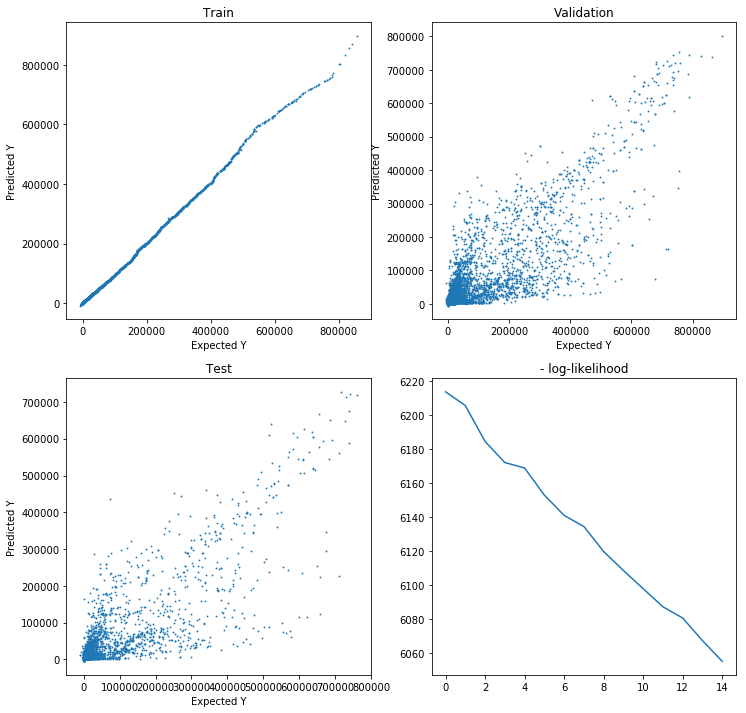

In [58]:

#pred_test = sess.run(m.predict(X_test))
#pred_train = sess.run(m.predict(X_train))
pred_test = minmax_y.inverse_transform(pred_test)[:X_test.shape[0]]
pred_dev = minmax_y.inverse_transform(pred_dev)[:X_dev.shape[0]]
pred_train = minmax_y.inverse_transform(pred_train)[:X_train.shape[0]]
error_train = pred_train-y_train_unscaled
error_pred = pred_test - y_test_unscaled
error_dev = pred_dev-y_dev_unscaled
print("Result before validation:")
print("{:<14}{:<10}{:<10}{:<10}".format("Difference","% train","% vad","% test"))
for r in [10,100,1000,10000]:
        print("{:<14}".format(str(r)),end='')
        print("{:<10.2f}".format(sum(abs(error_train)<r)[0]/error_train.shape[0]*100),end='')
        print("{:<10.2f}".format(sum(abs(error_dev)<r)[0]/error_dev.shape[0]*100),end='')
        print("{:<10.2f}".format(sum(abs(error_pred)<r)[0]/error_pred.shape[0]*100))

fig = plt.figure(figsize=(12, 12))
f2 = fig.add_subplot(221)
f2.scatter(y_train_unscaled,pred_train,s=0.7)
f2.set_title('Train')
f2.set_xlabel('Expected Y')
f2.set_ylabel('Predicted Y')

f3 = fig.add_subplot(222)
f3.scatter(y_dev_unscaled,pred_dev,s=0.7)
f3.set_title('Validation')
f3.set_xlabel('Expected Y')
f3.set_ylabel('Predicted Y')

f4 = fig.add_subplot(223)
f4.scatter(y_test_unscaled,pred_test,s=0.7)
f4.set_title('Test')
f4.set_xlabel('Expected Y')
f4.set_ylabel('Predicted Y')

f5 = fig.add_subplot(224)
f5.plot(loss_vec)
f5.set_title("- log-likelihood")

plt.show()

Difference    % train   % vad     % test    
10            20.73     3.34      3.41      
100           47.47     11.34     11.78     
1000          76.07     31.91     31.81     
10000         97.48     64.71     65.06     


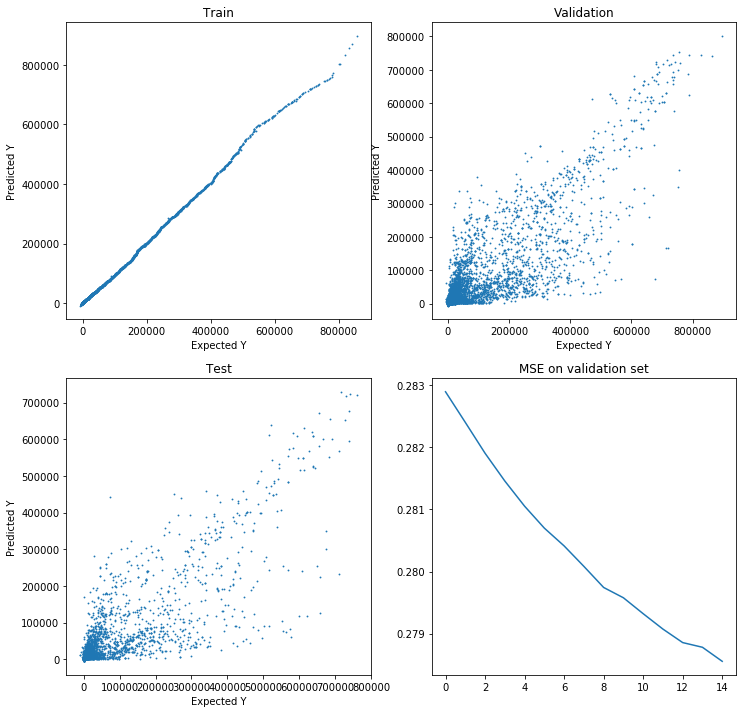

In [59]:

#pred_test = sess.run(m.predict(X_test))
#pred_train = sess.run(m.predict(X_train))
pred_test_1 = minmax_y.inverse_transform(pred_test_1)[:X_test.shape[0]]
pred_dev_1 = minmax_y.inverse_transform(pred_dev_1)[:X_dev.shape[0]]
pred_train_1 = minmax_y.inverse_transform(pred_train_1)[:X_train.shape[0]]
error_train_1 = pred_train_1-y_train_unscaled
error_pred_1 = pred_test_1 - y_test_unscaled
error_dev_1 = pred_dev_1-y_dev_unscaled

print("{:<14}{:<10}{:<10}{:<10}".format("Difference","% train","% vad","% test"))
for r in [10,100,1000,10000]:
        print("{:<14}".format(str(r)),end='')
        print("{:<10.2f}".format(sum(abs(error_train_1)<r)[0]/error_train_1.shape[0]*100),end='')
        print("{:<10.2f}".format(sum(abs(error_dev_1)<r)[0]/error_dev_1.shape[0]*100),end='')
        print("{:<10.2f}".format(sum(abs(error_pred_1)<r)[0]/error_pred_1.shape[0]*100))

fig = plt.figure(figsize=(12, 12))
f2 = fig.add_subplot(221)
f2.scatter(y_train_unscaled,pred_train_1,s=0.7)
f2.set_title('Train')
f2.set_xlabel('Expected Y')
f2.set_ylabel('Predicted Y')

f3 = fig.add_subplot(222)
f3.scatter(y_dev_unscaled,pred_dev_1,s=0.7)
f3.set_title('Validation')
f3.set_xlabel('Expected Y')
f3.set_ylabel('Predicted Y')

f4 = fig.add_subplot(223)
f4.scatter(y_test_unscaled,pred_test_1,s=0.7)
f4.set_title('Test')
f4.set_xlabel('Expected Y')
f4.set_ylabel('Predicted Y')

f5 = fig.add_subplot(224)
f5.plot(loss_vec_1)
f5.set_title("MSE on validation set")

plt.show()

In [ ]:
with tf.device(":/cpu:0"):
    cost = tf.reduce_mean(tf.squared_difference(m.predict(X_train),y_train))
    minimize_cost = optimizer.minimize(cost)
    cost_vec = []
    print("Train to minimize MSE on training set:")
    tstart = time.time()
    for i in range(10):
        start = time.time()
        _, c = sess.run([minimize_cost,cost])
        print("Iter:",i+1,", Time:","{:.2f}".format((time.time()-start)/60),"min, MSE =",c)
        loss_vec.append(c)
    print("Total time:","{:.2f}".format((time.time()-tstart)/60),"min")
    
    pred_test = sess.run(m.predict(X_test))
    pred_train = sess.run(m.predict(X_train))

In [31]:
sess.close()

In [ ]:
ls_1 = para_list[95][0]
ls = para_list[95][2]
print(para_list[95][0],para_list[95][2])

In [ ]:
print(sess.run(tf.eye(5,dtype=tf.float32)*1.2+tf.eye(5,dtype=tf.float32)))

In [32]:
print(sess.run(tf.exp(-8.)))

0.000335463


In [38]:
para_list[-1]

[nan,
 nan,
 array([[ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32),
 0.1]

[[ 0.07791224  0.07789297  0.07789644 ...,  0.07791172  0.07792485
   0.07794192]]
